In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv(r"C:\Users\ASUS\Downloads\train.csv")

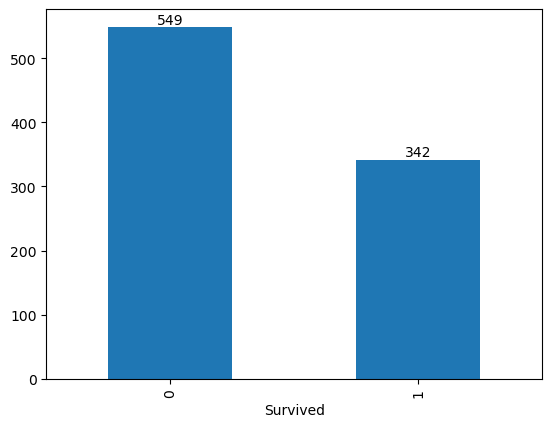

In [3]:
ax=df['Survived'].value_counts().plot(kind='bar')
for bars in ax.containers:
    ax.bar_label(bars)

In [4]:
df['Cabin']=df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [5]:
from sklearn.impute import KNNImputer
k=KNNImputer(n_neighbors=3)
df['Age']=k.fit_transform(df[['Age']])

In [6]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,1,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,1,C


In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(889, 12)

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
s=SMOTE(random_state=0)

In [11]:
def t_num(x):
    return x.split(" ")[-1]
        
def t_item(x):
    items = x.split(" ")
    if len(items) == 1:
        return "NONE"
    return "_".join(items[0:-1])

def pre(df):
    d=df.copy()
    d['T_No']=d['Ticket'].apply(t_num)
    d['T_item']=d['Ticket'].apply(t_item)
    return d

In [12]:
df_new=pre(df)

In [13]:
d=df_new

In [14]:
d['T_item']=d['T_item'].apply(lambda x: 0 if x=='NONE' else 1)
d=d.drop(columns=['PassengerId','Ticket'])
d.drop(columns=['Name','T_No'],inplace=True)

In [15]:
d

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,T_item
0,0,3,male,22.000000,1,0,7.2500,0,S,1
1,1,1,female,38.000000,1,0,71.2833,1,C,1
2,1,3,female,26.000000,0,0,7.9250,0,S,1
3,1,1,female,35.000000,1,0,53.1000,1,S,0
4,0,3,male,35.000000,0,0,8.0500,0,S,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,0,S,0
887,1,1,female,19.000000,0,0,30.0000,1,S,0
888,0,3,female,29.699118,1,2,23.4500,0,S,1
889,1,1,male,26.000000,0,0,30.0000,1,C,0


In [16]:
d=d[d['Fare']<100]

In [17]:
d.shape

(836, 10)

In [18]:
d=pd.get_dummies(d,drop_first=True)
X=d.drop(columns='Survived')
y=d['Survived']

In [19]:
X_res,y_res=s.fit_resample(X,y)

In [20]:
X_res.shape

(1070, 10)

In [21]:
X_res=X_res.astype(int)

<Axes: xlabel='Survived'>

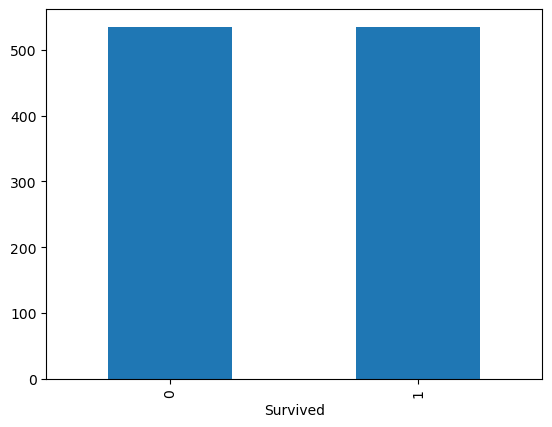

In [22]:
y_res.value_counts().plot(kind='bar')

In [23]:
st=StandardScaler()

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_res,y_res,random_state=42,test_size=0.2)

In [25]:
X_train=st.fit_transform(X_train)
X_val=st.transform(X_val)

In [26]:
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector
x=XGBClassifier()
p={'n_estimators':[10,50,100,120,500],'learning_rate':[0.0001,0.001,0.01,0.5,0.75,1],'max_depth':[1,10,15,None]}
from sklearn.model_selection import GridSearchCV
g=GridSearchCV(x,p,cv=10,n_jobs=-1)
g.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.5, 0.75, 1],
                         'max_depth': [1, 10, 15, None],
                         'n_estimators': [10, 50, 100, 120, 500]})

In [27]:
g.best_params_

{'learning_rate': 0.5, 'max_depth': 15, 'n_estimators': 50}

In [28]:
efs=ExhaustiveFeatureSelector(XGBClassifier(**g.best_params_),min_features=4,max_features=10,cv=10,n_jobs=-1)

In [29]:
efs.fit(X_train,y_train)

Features: 848/848

ExhaustiveFeatureSelector(cv=10,
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learn...
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=15, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=50, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=None, ...),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6],
                                          [7], [8], [9]],
                          max_features=10, min_features=4, n_jobs=-1)

In [30]:
efs.best_idx_

(0, 1, 3, 4, 5, 7)

In [33]:
model=XGBClassifier(**g.best_params_)
model.fit(X_train[:,(0,1,3,4,5,7)],y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
x=ConfusionMatrixDisplay(confusion_matrix(y_val,model.predict(X_val[:,(0,1,3,4,5,7)])),display_labels=model.classes_)

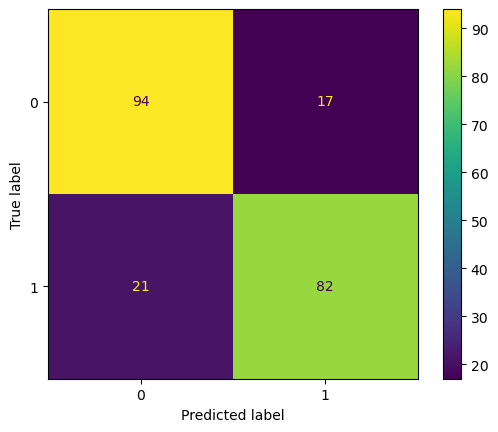

In [47]:
x.plot()

In [49]:
from sklearn.metrics import accuracy_score
a=accuracy_score(y_val,model.predict(X_val[:,(0,1,3,4,5,7)]))

In [59]:
X_res

,Pclass,Age,SibSp,Parch,Fare,Cabin,T_item,Sex_male,Embarked_Q,Embarked_S
0,3,22,1,0,7,0,1,1,0,1
1,1,38,1,0,71,1,1,0,0,0
2,3,26,0,0,7,0,1,0,0,1
3,1,35,1,0,53,1,0,0,0,1
4,3,35,0,0,8,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1065,3,3,0,1,13,0,0,0,0,1
1066,3,19,1,0,7,0,0,1,0,1
1067,1,30,0,0,56,0,0,1,0,1
1068,2,30,0,0,13,0,0,1,0,1


In [60]:
pre=X_res.drop(columns=['SibSp','T_item','Embarked_Q','Embarked_S'])

In [62]:
pre.shape

(1070, 6)

In [63]:
import mlflow
import mlflow.sklearn

In [40]:
!conda create -n mlflowtest python=3.8 -y

Retrieving notices: ...working... done



CondaValueError: prefix already exists: C:\Users\ASUS\.conda\envs\mlflowtest



In [41]:
!conda activate mlflowtest

In [42]:
from mlflow.models import infer_signature

In [44]:
mlflow.set_experiment('Titanic')

2024/03/22 16:51:25 INFO mlflow.tracking.fluent: Experiment with name 'Titanic' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/ASUS/mlruns/402358499065253333', creation_time=1711106485806, experiment_id='402358499065253333', last_update_time=1711106485806, lifecycle_stage='active', name='Titanic', tags={}>

In [66]:
with mlflow.start_run():
    mlflow.log_params(g.best_params_)
    mlflow.log_metric('Accuracy',a)
    mlflow.set_tag('Information','XGBoost Classifier for Titanic Data Set')
    sig=infer_signature(X_res,model.predict(pre))
    info=mlflow.sklearn.log_model(sk_model=model,artifact_path='Titanic Model',signature=sig,input_example=X_res,registered_model_name='Titanic Quickstart')    

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to u